Convenxt v2

成功加载 1210 条记录
发展期记录: 596, 稳定期记录: 614
构建图像对...


提取特征: 100%|██████████| 605/605 [09:24<00:00,  1.07对/s]


可视化结果已保存至: ./results\feature_tsne_visualization.png


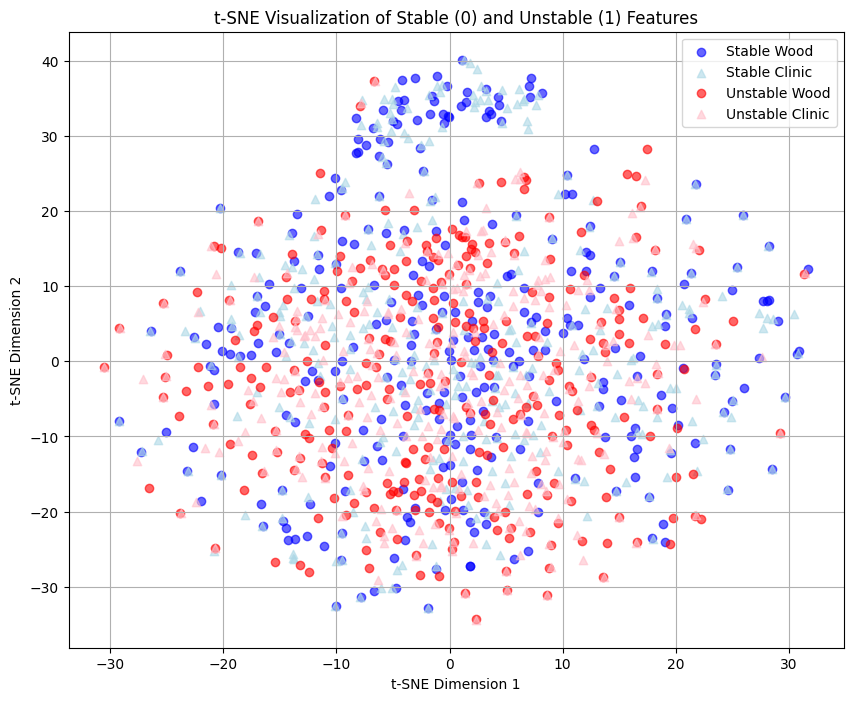

In [ ]:
import torch
import timm
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
import pandas as pd

class Config:
    def __init__(self):
        self.save_dir = '../../../outputs/results'
        self.img_size = 224

config = Config()


os.makedirs(config.save_dir, exist_ok=True)


CSV_PATH = '../../../datasets/data.csv'
df = pd.read_csv(CSV_PATH)
print(f"成功加载 {len(df)} 条记录")


dev_df = df[df['stability'] == 'non-stable']
stable_df = df[df['stability'] == 'stable']
print(f"发展期记录: {len(dev_df)}, 稳定期记录: {len(stable_df)}")


print("构建图像对...")
dev_pairs = []
dev_pair_ids = dev_df['pair_id'].unique()
for pair_id in dev_pair_ids:
    pair_images = dev_df[dev_df['pair_id'] == pair_id]
    wood_image = pair_images[pair_images['image_type'] == 'wood'].iloc[0]
    clinic_image = pair_images[pair_images['image_type'] == 'clinic'].iloc[0]
    dev_pairs.append({'wood': wood_image['image_path'], 'clinic': clinic_image['image_path']})

stable_pairs = []
stable_pair_ids = stable_df['pair_id'].unique()
for pair_id in stable_pair_ids:
    pair_images = stable_df[stable_df['pair_id'] == pair_id]
    wood_image = pair_images[pair_images['image_type'] == 'wood'].iloc[0]
    clinic_image = pair_images[pair_images['image_type'] == 'clinic'].iloc[0]
    stable_pairs.append({'wood': wood_image['image_path'], 'clinic': clinic_image['image_path']})


pairs = []
labels = []
for pair in stable_pairs:
    pairs.append({'wood': {'image_path': pair['wood'], 'label': 0}, 'clinic': {'image_path': pair['clinic'], 'label': 0}})
    labels.append(0)  # stable: 0
for pair in dev_pairs:
    pairs.append({'wood': {'image_path': pair['wood'], 'label': 1}, 'clinic': {'image_path': pair['clinic'], 'label': 1}})
    labels.append(1)  # non-stable: 1


model = timm.create_model(
    'convnextv2_tiny',
    pretrained=True,
    features_only=True,
    out_indices=[0, 2, 3]  
)
model.eval()


data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
transform = timm.data.create_transform(**data_cfg)


wood_features_list = []
clinic_features_list = []
labels_list = []


with torch.no_grad():
    for pair in tqdm(pairs, desc="提取特征", unit="对"):

        wood_img = Image.open(pair['wood']['image_path']).convert("RGB")
        clinic_img = Image.open(pair['clinic']['image_path']).convert("RGB")
        wood_tensor = transform(wood_img).unsqueeze(0)
        clinic_tensor = transform(clinic_img).unsqueeze(0)
        

        wood_features = model(wood_tensor)
        clinic_features = model(clinic_tensor)
        

        wood_flat = [feat.flatten(1) for feat in wood_features]
        clinic_flat = [feat.flatten(1) for feat in clinic_features]
        wood_concat = torch.cat(wood_flat, dim=1).cpu().numpy()
        clinic_concat = torch.cat(clinic_flat, dim=1).cpu().numpy()
        
        wood_features_list.append(wood_concat)
        clinic_features_list.append(clinic_concat)
        labels_list.append(pair['wood']['label'])


wood_features_array = np.vstack(wood_features_list)
clinic_features_array = np.vstack(clinic_features_list)
labels_array = np.array(labels_list)


all_features = np.vstack([wood_features_array, clinic_features_array])
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(all_features)


n_samples = len(pairs)
wood_tsne = tsne_results[:n_samples]
clinic_tsne = tsne_results[n_samples:]

plt.figure(figsize=(10, 8))


stable_idx = labels_array == 0
plt.scatter(
    wood_tsne[stable_idx, 0], wood_tsne[stable_idx, 1],
    c='blue', marker='o', label='Stable Wood', alpha=0.6
)
plt.scatter(
    clinic_tsne[stable_idx, 0], clinic_tsne[stable_idx, 1],
    c='lightblue', marker='^', label='Stable Clinic', alpha=0.6
)


unstable_idx = labels_array == 1
plt.scatter(
    wood_tsne[unstable_idx, 0], wood_tsne[unstable_idx, 1],
    c='red', marker='o', label='Unstable Wood', alpha=0.6
)
plt.scatter(
    clinic_tsne[unstable_idx, 0], clinic_tsne[unstable_idx, 1],
    c='pink', marker='^', label='Unstable Clinic', alpha=0.6
)

plt.title('t-SNE Visualization of Stable (0) and Unstable (1) Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)

save_path = os.path.join(config.save_dir, 'feature_tsne_visualization.png')
plt.savefig(save_path)
print(f"可视化结果已保存至: {save_path}")
plt.show()

成功加载 1210 条记录
发展期记录: 596, 稳定期记录: 614
构建图像对...


提取并融合特征: 100%|██████████| 605/605 [06:48<00:00,  1.48对/s]


可视化结果已保存至: ./results\feature_tsne_fused.png


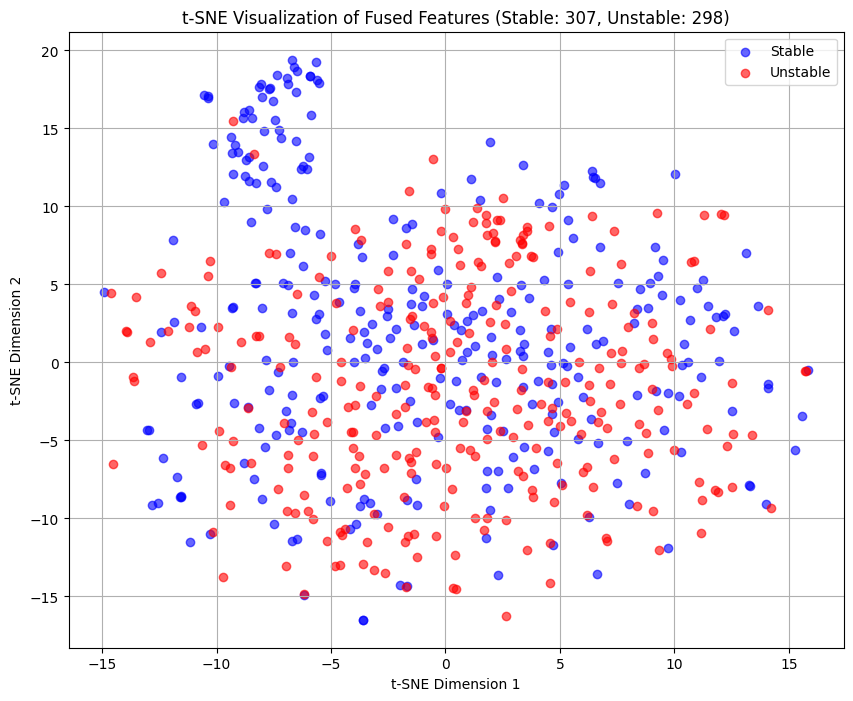

In [ ]:
import torch
import timm
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
import pandas as pd


class Config:
    def __init__(self):
        self.save_dir = '../../../outputs/results'
        self.img_size = 224





config = Config()
os.makedirs(config.save_dir, exist_ok=True)

CSV_PATH = '../../../datasets/data.csv'

df = pd.read_csv(CSV_PATH)
print(f"成功加载 {len(df)} 条记录")



dev_df = df[df['stability'] == 'non-stable']
stable_df = df[df['stability'] == 'stable']
print(f"发展期记录: {len(dev_df)}, 稳定期记录: {len(stable_df)}")





print("构建图像对...")
dev_pairs = []
dev_pair_ids = dev_df['pair_id'].unique()
for pair_id in dev_pair_ids:
    pair_images = dev_df[dev_df['pair_id'] == pair_id]
    wood_image = pair_images[pair_images['image_type'] == 'wood']
    clinic_image = pair_images[pair_images['image_type'] == 'clinic']
    if len(wood_image) > 0 and len(clinic_image) > 0:
        dev_pairs.append({
            'wood': wood_image.iloc[0]['image_path'],
            'clinic': clinic_image.iloc[0]['image_path']
        })
    else:
        print(f"警告：pair_id {pair_id} 缺少 wood 或 clinic 图像，跳过。")

stable_pairs = []
stable_pair_ids = stable_df['pair_id'].unique()
for pair_id in stable_pair_ids:
    pair_images = stable_df[stable_df['pair_id'] == pair_id]
    wood_image = pair_images[pair_images['image_type'] == 'wood']
    clinic_image = pair_images[pair_images['image_type'] == 'clinic']
    if len(wood_image) > 0 and len(clinic_image) > 0:
        stable_pairs.append({
            'wood': wood_image.iloc[0]['image_path'],
            'clinic': clinic_image.iloc[0]['image_path']
        })
    else:
        print(f"警告：pair_id {pair_id} 缺少 wood 或 clinic 图像，跳过。")





pairs = []
labels = []
for pair in stable_pairs:
    pairs.append({'wood': {'image_path': pair['wood'], 'label': 0}, 'clinic': {'image_path': pair['clinic'], 'label': 0}})
    labels.append(0)  # stable: 0
for pair in dev_pairs:
    pairs.append({'wood': {'image_path': pair['wood'], 'label': 1}, 'clinic': {'image_path': pair['clinic'], 'label': 1}})
    labels.append(1)  # non-stable: 1



model = timm.create_model(
    'convnextv2_tiny',
    pretrained=True,
    features_only=True,
    out_indices=[0, 2, 3]  
)
model.eval()



data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
transform = timm.data.create_transform(**data_cfg)


fused_features_list = []
labels_list = []


with torch.no_grad():
    for pair in tqdm(pairs, desc="提取并融合特征", unit="对"):


        wood_img = Image.open(pair['wood']['image_path']).convert("RGB")
        clinic_img = Image.open(pair['clinic']['image_path']).convert("RGB")
        wood_tensor = transform(wood_img).unsqueeze(0)
        clinic_tensor = transform(clinic_img).unsqueeze(0)
        

        wood_features = model(wood_tensor)
        clinic_features = model(clinic_tensor)
        

        wood_flat = [feat.flatten(1) for feat in wood_features]
        clinic_flat = [feat.flatten(1) for feat in clinic_features]
        wood_concat = torch.cat(wood_flat, dim=1)
        clinic_concat = torch.cat(clinic_flat, dim=1)
        

        fused_concat = (wood_concat + clinic_concat) / 2.0
        fused_concat = fused_concat.cpu().numpy()
        
        fused_features_list.append(fused_concat)
        labels_list.append(pair['wood']['label'])






fused_features_array = np.vstack(fused_features_list)
labels_array = np.array(labels_list)



tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(fused_features_array)



plt.figure(figsize=(10, 8))

stable_idx = labels_array == 0
plt.scatter(
    tsne_results[stable_idx, 0], tsne_results[stable_idx, 1],
    c='blue', marker='o', label='Stable', alpha=0.6
)


unstable_idx = labels_array == 1
plt.scatter(
    tsne_results[unstable_idx, 0], tsne_results[unstable_idx, 1],
    c='red', marker='o', label='Unstable', alpha=0.6
)

plt.title(f't-SNE Visualization of Fused Features (Stable: {sum(stable_idx)}, Unstable: {sum(unstable_idx)})')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)

save_path = os.path.join(config.save_dir, 'feature_tsne_fused.png')
plt.savefig(save_path)

plt.show()

成功加载 1210 条记录
发展期记录: 596, 稳定期记录: 614


提取并融合特征: 100%|██████████| 605/605 [07:28<00:00,  1.35对/s]


PCA 降维完成，保留 50 个主成分，解释方差比例：0.6657
PCA 特征和模型已保存至 ./results
Random Forest 训练完成
Random Forest 模型已保存至 ./results
特征重要性排名前两维的主成分索引：[0 8]
对应重要性分数：[0.06023807 0.0356222 ]
可视化结果已保存至: ./results\feature_pca_rf_visualization.png


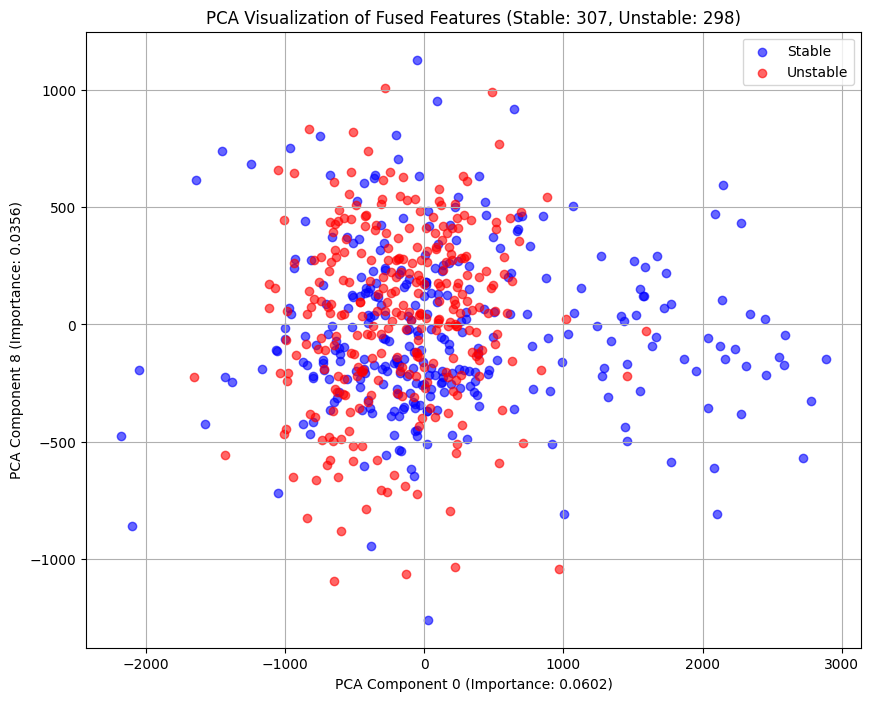

特征重要性直方图已保存至: ./results\feature_importance_histogram.png


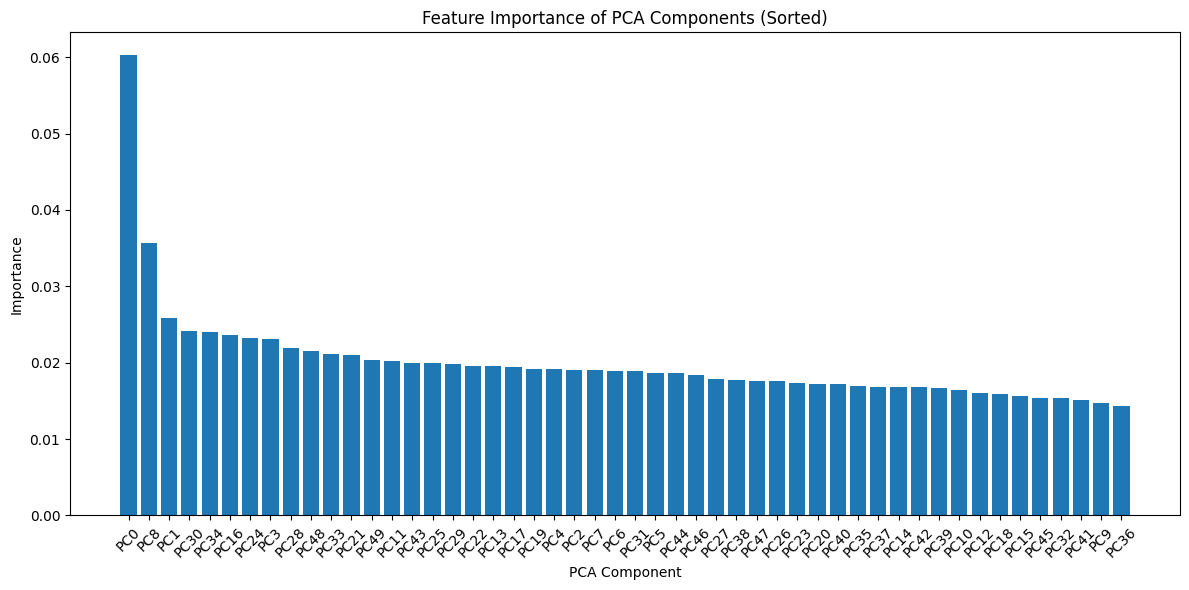

In [ ]:
import torch
import timm
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import os
import pandas as pd
import joblib

class Config:
    def __init__(self):
        self.save_dir = '../../../outputs/results'
        self.img_size = 224
        self.pca_n_components = 50

config = Config()
os.makedirs(config.save_dir, exist_ok=True)

CSV_PATH = '../../../datasets/data.csv'
df = pd.read_csv(CSV_PATH)
print(f"成功加载 {len(df)} 条记录")

dev_df = df[df['stability'] == 'non-stable']
stable_df = df[df['stability'] == 'stable']
print(f"发展期记录: {len(dev_df)}, 稳定期记录: {len(stable_df)}")

dev_pairs = []
dev_pair_ids = dev_df['pair_id'].unique()
for pair_id in dev_pair_ids:
    pair_images = dev_df[dev_df['pair_id'] == pair_id]
    wood_image = pair_images[pair_images['image_type'] == 'wood'].iloc[0]
    clinic_image = pair_images[pair_images['image_type'] == 'clinic'].iloc[0]
    dev_pairs.append({
        'wood': wood_image['image_path'],
        'clinic': clinic_image['image_path']
    })

stable_pairs = []
stable_pair_ids = stable_df['pair_id'].unique()
for pair_id in stable_pair_ids:
    pair_images = stable_df[stable_df['pair_id'] == pair_id]
    wood_image = pair_images[pair_images['image_type'] == 'wood'].iloc[0]
    clinic_image = pair_images[pair_images['image_type'] == 'clinic'].iloc[0]
    stable_pairs.append({
        'wood': wood_image['image_path'],
        'clinic': clinic_image['image_path']
    })

pairs = []
labels = []
for pair in stable_pairs:
    pairs.append({'wood': {'image_path': pair['wood'], 'label': 0}, 'clinic': {'image_path': pair['clinic'], 'label': 0}})
    labels.append(0)
for pair in dev_pairs:
    pairs.append({'wood': {'image_path': pair['wood'], 'label': 1}, 'clinic': {'image_path': pair['clinic'], 'label': 1}})
    labels.append(1)

model = timm.create_model(
    'convnextv2_tiny',
    pretrained=True,
    features_only=True,
    out_indices=[0, 2, 3]
)
model.eval()

data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
transform = timm.data.create_transform(**data_cfg)

fused_features_list = []
labels_list = []

with torch.no_grad():
    for pair in tqdm(pairs, desc="提取并融合特征", unit="对"):
        wood_img = Image.open(pair['wood']['image_path']).convert("RGB")
        clinic_img = Image.open(pair['clinic']['image_path']).convert("RGB")
        wood_tensor = transform(wood_img).unsqueeze(0)
        clinic_tensor = transform(clinic_img).unsqueeze(0)
        
        wood_features = model(wood_tensor)
        clinic_features = model(clinic_tensor)
        
        wood_flat = [feat.flatten(1) for feat in wood_features]
        clinic_flat = [feat.flatten(1) for feat in clinic_features]
        wood_concat = torch.cat(wood_flat, dim=1)
        clinic_concat = torch.cat(clinic_flat, dim=1)
        
        fused_concat = (wood_concat + clinic_concat) / 2.0
        fused_concat = fused_concat.cpu().numpy()
        
        fused_features_list.append(fused_concat)
        labels_list.append(pair['wood']['label'])

X = np.vstack(fused_features_list)
Y = np.array(labels_list)

pca = PCA(n_components=config.pca_n_components)
X_pca = pca.fit_transform(X)
print(f"PCA 降维完成，保留 {config.pca_n_components} 个主成分，解释方差比例：{sum(pca.explained_variance_ratio_):.4f}")

np.save(os.path.join(config.save_dir, 'X_pca.npy'), X_pca)
np.save(os.path.join(config.save_dir, 'Y.npy'), Y)
joblib.dump(pca, os.path.join(config.save_dir, 'pca_model.joblib'))
print(f"PCA 特征和模型已保存至 {config.save_dir}")

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_pca, Y)
print("Random Forest 训练完成")

joblib.dump(rf, os.path.join(config.save_dir, 'rf_model.joblib'))
print(f"Random Forest 模型已保存至 {config.save_dir}")

feature_importances = rf.feature_importances_
top_indices = np.argsort(feature_importances)[::-1][:2]
print(f"特征重要性排名前两维的主成分索引：{top_indices}")
print(f"对应重要性分数：{feature_importances[top_indices]}")

plt.figure(figsize=(10, 8))
stable_idx = Y == 0
plt.scatter(
    X_pca[stable_idx, top_indices[0]], X_pca[stable_idx, top_indices[1]],
    c='blue', marker='o', label='Stable', alpha=0.6
)
unstable_idx = Y == 1
plt.scatter(
    X_pca[unstable_idx, top_indices[0]], X_pca[unstable_idx, top_indices[1]],
    c='red', marker='o', label='Unstable', alpha=0.6
)
plt.title(f'PCA Visualization of Fused Features (Stable: {sum(stable_idx)}, Unstable: {sum(unstable_idx)})')
plt.xlabel(f'PCA Component {top_indices[0]} (Importance: {feature_importances[top_indices[0]]:.4f})')
plt.ylabel(f'PCA Component {top_indices[1]} (Importance: {feature_importances[top_indices[1]]:.4f})')
plt.legend()
plt.grid(True)
save_path = os.path.join(config.save_dir, 'feature_pca_rf_visualization.png')
plt.savefig(save_path)
print(f"可视化结果已保存至: {save_path}")
plt.show()

plt.figure(figsize=(12, 6))
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=[f'PC{i}' for i in sorted_indices])
plt.title('Feature Importance of PCA Components (Sorted)')
plt.xlabel('PCA Component')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
save_path_histogram = os.path.join(config.save_dir, 'feature_importance_histogram.png')
plt.savefig(save_path_histogram)
print(f"特征重要性直方图已保存至: {save_path_histogram}")
plt.show()

In [ ]:
import torch
import timm
from PIL import Image
import torch.nn.functional as F
import numpy as np
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm



# 配置参数
CSV_PATH = '../../../datasets/data.csv' 
MODEL_NAME = 'vit_base_patch16_224'
N_COMPONENTS = 2

# 加载数据
print("===== 数据加载阶段 =====")
df = pd.read_csv(CSV_PATH)
print(f"成功加载 {len(df)} 条记录")



# 分离发展期和稳定期
dev_df = df[df['stability'] == 'non-stable']
stable_df = df[df['stability'] == 'stable']
print(f"发展期记录: {len(dev_df)}, 稳定期记录: {len(stable_df)}")

# 构建图像对
print("构建图像对...")
dev_pairs = []
dev_pair_ids = dev_df['pair_id'].unique()
for pair_id in dev_pair_ids:
    pair_images = dev_df[dev_df['pair_id'] == pair_id]
    wood_image = pair_images[pair_images['image_type'] == 'wood'].iloc[0]
    clinic_image = pair_images[pair_images['image_type'] == 'clinic'].iloc[0]
    dev_pairs.append({'wood': wood_image['image_path'], 'clinic': clinic_image['image_path']})

stable_pairs = []
stable_pair_ids = stable_df['pair_id'].unique()
for pair_id in stable_pair_ids:
    pair_images = stable_df[stable_df['pair_id'] == pair_id]
    wood_image = pair_images[pair_images['image_type'] == 'wood'].iloc[0]
    clinic_image = pair_images[pair_images['image_type'] == 'clinic'].iloc[0]
    stable_pairs.append({'wood': wood_image['image_path'], 'clinic': clinic_image['image_path']})


c:\Users\chris\anaconda3\envs\PanDerm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


===== 数据加载阶段 =====
成功加载 1210 条记录
发展期记录: 596, 稳定期记录: 614
构建图像对...


In [ ]:
# 创建ViT模型并加载预训练权重
print("\n===== 模型初始化阶段 =====")
print("加载预训练ViT模型...")
model = timm.create_model(MODEL_NAME, checkpoint_path='../../../outputs/checkpoints/proposed/pytorch_model.bin')
model.eval()


data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
transform = timm.data.create_transform(**data_cfg)

# 提取特征
print("\n===== 特征提取阶段 =====")
print("提取发展期图像特征...")
dev_wood_features = []
dev_clinic_features = []
for pair in dev_pairs:
    try:

        wood_img = Image.open(pair['wood']).convert("RGB")
        wood_tensor = transform(wood_img).unsqueeze(0)
        with torch.no_grad():
            wood_feature = model.forward_features(wood_tensor).squeeze()[0].cpu().numpy()
        dev_wood_features.append(wood_feature)
        
        # 提取临床图像特征
        clinic_img = Image.open(pair['clinic']).convert("RGB")
        clinic_tensor = transform(clinic_img).unsqueeze(0)
        with torch.no_grad():
            clinic_feature = model.forward_features(clinic_tensor).squeeze()[0].cpu().numpy()
        dev_clinic_features.append(clinic_feature)
    except Exception as e:
        print(f"图像加载错误 {pair['wood']} 或 {pair['clinic']}: {str(e)}")
        dev_wood_features.append(None)
        dev_clinic_features.append(None)

print(f"发展期有效样本: {sum(1 for f in dev_wood_features if f is not None)}")

print("提取稳定期图像特征...")
stable_wood_features = []
stable_clinic_features = []
for pair in stable_pairs:
    try:
        # 提取Wood灯图像特征
        wood_img = Image.open(pair['wood']).convert("RGB")
        wood_tensor = transform(wood_img).unsqueeze(0)
        with torch.no_grad():
            wood_feature = model.forward_features(wood_tensor).squeeze()[0].cpu().numpy()
        stable_wood_features.append(wood_feature)
        
        # 提取临床图像特征
        clinic_img = Image.open(pair['clinic']).convert("RGB")
        clinic_tensor = transform(clinic_img).unsqueeze(0)
        with torch.no_grad():
            clinic_feature = model.forward_features(clinic_tensor).squeeze()[0].cpu().numpy()
        stable_clinic_features.append(clinic_feature)
    except Exception as e:
        print(f"图像加载错误 {pair['wood']} 或 {pair['clinic']}: {str(e)}")
        stable_wood_features.append(None)
        stable_clinic_features.append(None)

print(f"稳定期有效样本: {sum(1 for f in stable_wood_features if f is not None)}")




===== 模型初始化阶段 =====
加载预训练ViT模型...


c:\Users\chris\anaconda3\envs\PanDerm\lib\site-packages\timm\models\_helpers.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, ma


===== 特征提取阶段 =====
提取发展期图像特征...
发展期有效样本: 298
提取稳定期图像特征...
稳定期有效样本: 307


In [45]:
from sklearn.preprocessing import StandardScaler
N_COMPONENTS = 100
wood_scaler = StandardScaler()
clinic_scaler = StandardScaler()
dev_wood = np.array(dev_wood_features)
dev_clinic = np.array(dev_clinic_features)
dev_wood = wood_scaler.fit_transform(dev_wood)
dev_clinic = clinic_scaler.fit_transform(dev_clinic)
dev = np.concatenate((dev_wood, dev_clinic), axis=1)
stable_wood = np.array(stable_wood_features)    
stable_clinic = np.array(stable_clinic_features)
stable_wood = wood_scaler.transform(stable_wood)
stable_clinic = clinic_scaler.transform(stable_clinic)
stable = np.concatenate((stable_wood, stable_clinic), axis=1)[:dev.shape[0]]
cca = CCA(N_COMPONENTS)
dev_canonical, stable_canonical = cca.fit_transform(dev, stable)
correlations = np.corrcoef(dev_canonical.T, stable_canonical.T)[:N_COMPONENTS, N_COMPONENTS:]
print("典型变量对的相关系数:", np.diag(correlations))


典型变量对的相关系数: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
import seaborn as sns
from sklearn.datasets import make_multilabel_classification



dev_wood = np.array(dev_wood_features)
dev_clinic = np.array(dev_clinic_features)


stable_wood = np.array(stable_wood_features)    
stable_clinic = np.array(stable_clinic_features)




# # 设置中文字体，确保中文正常显示
# plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
# plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

# # 生成模拟数据
# def generate_simulated_data(n_samples=200, n_features_x=5, n_features_y=5, random_state=42):
#     """
#     生成两组相关的模拟数据
    
#     参数:
#     - n_samples: 样本数量
#     - n_features_x: 第一组特征数量
#     - n_features_y: 第二组特征数量
#     - random_state: 随机种子，保证结果可重现
    
#     返回:
#     - X: 第一组特征数据
#     - Y: 第二组特征数据
#     """
#     # 设置随机种子
#     np.random.seed(random_state)
    
#     # 生成第一组特征 (X) - 包含一些独立变量和相关变量
#     X = np.random.randn(n_samples, n_features_x)
    
#     # 生成第二组特征 (Y)，与X相关
#     # 创建一些X和Y之间的相关性
#     Y = np.zeros((n_samples, n_features_y))
#     Y[:, 0] = 2 * X[:, 0] + np.random.randn(n_samples) * 0.5  # Y的第一个特征与X的第一个特征强相关
#     Y[:, 1] = 1.5 * X[:, 1] + 0.8 * X[:, 2] + np.random.randn(n_samples) * 0.3  # Y的第二个特征与X的两个特征相关
#     Y[:, 2] = X[:, 3]**2 + np.random.randn(n_samples) * 0.2  # 非线性关系
#     Y[:, 3] = np.sin(X[:, 4]) + np.random.randn(n_samples) * 0.1  # 非线性关系
#     Y[:, 4] = np.random.randn(n_samples)  # 一个不相关的噪声特征
    
#     return X, Y

# # 生成发展期和稳定期的模拟数据
# dev_wood, dev_clinic = generate_simulated_data(n_samples=150, n_features_x=6, n_features_y=5, random_state=42)
# stable_wood, stable_clinic = generate_simulated_data(n_samples=120, n_features_x=6, n_features_y=5, random_state=43)

# 打印数据维度
print(f"发展期Wood特征形状: {dev_wood.shape}")
print(f"发展期Clinic特征形状: {dev_clinic.shape}")
print(f"稳定期Wood特征形状: {stable_wood.shape}")
print(f"稳定期Clinic特征形状: {stable_clinic.shape}")

# 计算特征间相关性
def check_collinearity(X, Y, name=""):
    """
    检查特征间的相关性
    
    参数:
    - X, Y: 要检查的两组特征
    - name: 数据组名称，用于打印输出
    """
    # 计算跨组相关系数矩阵
    corr_matrix = np.corrcoef(X.T, Y.T)
    max_corr = np.max(np.abs(corr_matrix[:X.shape[1], X.shape[1]:]))
    print(f"{name}最大跨组相关系数: {max_corr:.4f}")
    
    # 检查X内部相关性
    x_corr = np.corrcoef(X.T)
    x_max = np.max(np.abs(x_corr - np.eye(X.shape[1])))  # 排除对角线
    print(f"{name}X特征内部最大相关性: {x_max:.4f}")
    
    # 检查Y内部相关性
    y_corr = np.corrcoef(Y.T)
    y_max = np.max(np.abs(y_corr - np.eye(Y.shape[1])))  # 排除对角线
    print(f"{name}Y特征内部最大相关性: {y_max:.4f}")

# 检查相关性
check_collinearity(dev_wood, dev_clinic, "发展期")
check_collinearity(stable_wood, stable_clinic, "稳定期")

# 可视化特征间相关性
def visualize_correlation(X, Y, title, figsize=(12, 10)):
    """可视化两组特征之间的相关性"""
    # 标准化特征
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    X_std = scaler_X.fit_transform(X)
    Y_std = scaler_Y.fit_transform(Y)
    
    # 计算相关系数矩阵
    corr_matrix = np.corrcoef(X_std.T, Y_std.T)
    # 提取X和Y之间的跨组相关性
    cross_corr = corr_matrix[:X.shape[1], X.shape[1]:]
    
    # 创建画布
    plt.figure(figsize=figsize)
    # 使用seaborn绘制热图
    sns.heatmap(cross_corr, annot=True, cmap='coolwarm', fmt='.2f', 
                xticklabels=[f'临床特征{i+1}' for i in range(Y.shape[1])],
                yticklabels=[f'Wood特征{i+1}' for i in range(X.shape[1])])
    plt.title(f'{title}特征间相关性热图', fontsize=15)
    plt.tight_layout()
    plt.show()
    
    # 可视化X特征内部相关性
    plt.figure(figsize=figsize)
    x_corr = np.corrcoef(X_std.T)
    sns.heatmap(x_corr, annot=True, cmap='coolwarm', fmt='.2f',
                xticklabels=[f'Wood特征{i+1}' for i in range(X.shape[1])],
                yticklabels=[f'Wood特征{i+1}' for i in range(X.shape[1])])
    plt.title(f'{title}Wood特征内部相关性热图', fontsize=15)
    plt.tight_layout()
    plt.show()
    
    # 可视化Y特征内部相关性
    plt.figure(figsize=figsize)
    y_corr = np.corrcoef(Y_std.T)
    sns.heatmap(y_corr, annot=True, cmap='coolwarm', fmt='.2f',
                xticklabels=[f'临床特征{i+1}' for i in range(Y.shape[1])],
                yticklabels=[f'临床特征{i+1}' for i in range(Y.shape[1])])
    plt.title(f'{title}临床特征内部相关性热图', fontsize=15)
    plt.tight_layout()
    plt.show()

# 可视化发展期特征相关性
visualize_correlation(dev_wood, dev_clinic, "发展期")

# 可视化稳定期特征相关性
visualize_correlation(stable_wood, stable_clinic, "稳定期")

# CCA分析并可视化结果
def perform_cca(X, Y, n_components=2, title=""):
    """执行CCA分析并可视化结果"""
    # 标准化特征
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    X_std = scaler_X.fit_transform(X)
    Y_std = scaler_Y.fit_transform(Y)
    
    # 执行CCA
    cca = CCA(n_components=n_components)
    X_cca, Y_cca = cca.fit_transform(X_std, Y_std)
    
    # 计算典型相关系数
    corr_coefs = [np.corrcoef(X_cca[:, i], Y_cca[:, i])[0, 1] 
                 for i in range(n_components)]
    
    # 可视化CCA结果
    plt.figure(figsize=(10, 8))
    plt.scatter(X_cca[:, 0], Y_cca[:, 0], alpha=0.7, c='blue', label='样本')
    plt.title(f'{title}CCA分析: 第一对典型变量 (相关系数: {corr_coefs[0]:.4f})', fontsize=14)
    plt.xlabel('Wood特征典型变量1', fontsize=12)
    plt.ylabel('临床特征典型变量1', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    if n_components > 1:
        plt.figure(figsize=(10, 8))
        plt.scatter(X_cca[:, 1], Y_cca[:, 1], alpha=0.7, c='red', label='样本')
        plt.title(f'{title}CCA分析: 第二对典型变量 (相关系数: {corr_coefs[1]:.4f})', fontsize=14)
        plt.xlabel('Wood特征典型变量2', fontsize=12)
        plt.ylabel('临床特征典型变量2', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    # 可视化典型载荷(weights)
    plt.figure(figsize=(14, 10))
    
    # Wood特征载荷
    plt.subplot(2, 1, 1)
    plt.bar(range(X.shape[1]), cca.x_weights_[:, 0], color='skyblue', label='第一对载荷')
    if n_components > 1:
        plt.bar(range(X.shape[1]), cca.x_weights_[:, 1], color='lightgreen', label='第二对载荷', alpha=0.7)
    plt.title(f'{title}Wood特征的典型载荷', fontsize=14)
    plt.xlabel('特征索引', fontsize=12)
    plt.ylabel('载荷值', fontsize=12)
    plt.xticks(range(X.shape[1]))
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 临床特征载荷
    plt.subplot(2, 1, 2)
    plt.bar(range(Y.shape[1]), cca.y_weights_[:, 0], color='salmon', label='第一对载荷')
    if n_components > 1:
        plt.bar(range(Y.shape[1]), cca.y_weights_[:, 1], color='lightblue', label='第二对载荷', alpha=0.7)
    plt.title(f'{title}临床特征的典型载荷', fontsize=14)
    plt.xlabel('特征索引', fontsize=12)
    plt.ylabel('载荷值', fontsize=12)
    plt.xticks(range(Y.shape[1]))
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # 返回CCA模型和转换后的数据
    return cca, X_cca, Y_cca

# 对发展期数据执行CCA
print("发展期数据CCA分析:")
dev_cca, dev_X_cca, dev_Y_cca = perform_cca(dev_wood, dev_clinic, title="发展期")

# 对稳定期数据执行CCA
print("稳定期数据CCA分析:")
stable_cca, stable_X_cca, stable_Y_cca = perform_cca(stable_wood, stable_clinic, title="稳定期")

# 比较发展期和稳定期的CCA结果



# 修正后的比较函数
def compare_cca_results(dev_cca, stable_cca, dev_X, dev_Y, stable_X, stable_Y, title="发展期与稳定期CCA比较"):
    """比较两个不同组的CCA结果"""
    # 计算每组的典型相关系数
    # 注意：对于dev_cca，使用dev_X作为X变量，dev_Y作为Y变量
    # 对于stable_cca，使用stable_X作为X变量，stable_Y作为Y变量
    dev_X_cca, dev_Y_cca = dev_cca.transform(dev_X, dev_Y)
    stable_X_cca, stable_Y_cca = stable_cca.transform(stable_X, stable_Y)
    
    # 计算相关系数
    dev_corr_coefs = [np.corrcoef(dev_X_cca[:, i], dev_Y_cca[:, i])[0, 1] 
                     for i in range(dev_cca.n_components)]
    
    stable_corr_coefs = [np.corrcoef(stable_X_cca[:, i], stable_Y_cca[:, i])[0, 1] 
                        for i in range(stable_cca.n_components)]
    
    # 可视化典型相关系数比较
    plt.figure(figsize=(12, 8))
    n_pairs = min(len(dev_corr_coefs), len(stable_corr_coefs), 5)  # 最多比较5对
    pairs = range(1, n_pairs + 1)
    
    plt.bar([p - 0.2 for p in pairs], dev_corr_coefs[:n_pairs], width=0.4, 
            color='blue', alpha=0.7, label='发展期')
    plt.bar([p + 0.2 for p in pairs], stable_corr_coefs[:n_pairs], width=0.4, 
            color='green', alpha=0.7, label='稳定期')
    
    plt.title(f'{title}: 典型相关系数比较', fontsize=15)
    plt.xlabel('典型变量对', fontsize=12)
    plt.ylabel('相关系数', fontsize=12)
    plt.xticks(pairs)
    plt.ylim(0, 1.1)  # 设置y轴范围为0-1.1
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 在柱状图上方添加数值标签
    for i, v in enumerate(dev_corr_coefs[:n_pairs]):
        plt.text(i + 1 - 0.2, v + 0.02, f'{v:.4f}', ha='center', fontsize=10)
    for i, v in enumerate(stable_corr_coefs[:n_pairs]):
        plt.text(i + 1 + 0.2, v + 0.02, f'{v:.4f}', ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 比较载荷矩阵
    plt.figure(figsize=(16, 12))
    
    # 比较Wood特征载荷
    plt.subplot(2, 1, 1)
    max_features = min(dev_cca.x_weights_.shape[0], stable_cca.x_weights_.shape[0], 10)  # 最多显示10个特征
    
    for i in range(max_features):
        plt.plot([1, 2], [dev_cca.x_weights_[i, 0], stable_cca.x_weights_[i, 0]], 
                 marker='o', linestyle='-', label=f'Wood特征{i+1}')
    
    plt.title(f'{title}: Wood特征第一对典型载荷比较', fontsize=15)
    plt.xlabel('组别', fontsize=12)
    plt.ylabel('载荷值', fontsize=12)
    plt.xticks([1, 2], ['发展期', '稳定期'])
    plt.legend(loc='best', ncol=2)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 比较临床特征载荷
    plt.subplot(2, 1, 2)
    max_features = min(dev_cca.y_weights_.shape[0], stable_cca.y_weights_.shape[0], 10)  # 最多显示10个特征
    
    for i in range(max_features):
        plt.plot([1, 2], [dev_cca.y_weights_[i, 0], stable_cca.y_weights_[i, 0]], 
                 marker='s', linestyle='-', label=f'临床特征{i+1}')
    
    plt.title(f'{title}: 临床特征第一对典型载荷比较', fontsize=15)
    plt.xlabel('组别', fontsize=12)
    plt.ylabel('载荷值', fontsize=12)
    plt.xticks([1, 2], ['发展期', '稳定期'])
    plt.legend(loc='best', ncol=2)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# 其他代码保持不变...



# 比较发展期和稳定期的CCA结果
compare_cca_results(dev_cca, stable_cca, 
                    StandardScaler().fit_transform(dev_wood), 
                    StandardScaler().fit_transform(dev_clinic),
                    StandardScaler().fit_transform(stable_wood), 
                    StandardScaler().fit_transform(stable_clinic))

发展期Wood特征形状: (298, 768)
发展期Clinic特征形状: (298, 768)
稳定期Wood特征形状: (307, 768)
稳定期Clinic特征形状: (307, 768)
发展期最大跨组相关系数: 0.7284
发展期X特征内部最大相关性: 0.6578
发展期Y特征内部最大相关性: 0.6902
稳定期最大跨组相关系数: 0.7593
稳定期X特征内部最大相关性: 0.6434
稳定期Y特征内部最大相关性: 0.7192


findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: Font family 'WenQuanYi Micro Hei' not found.
findfont: Font family 'Heiti TC' not found.
findfont: 